### Loading

In [1]:
!aws s3 ls

2024-04-08 03:18:12 aws-logs-590183878063-us-east-1
2024-04-19 21:26:00 dsci-finalproject
2024-04-12 22:04:47 dscisparkify-arshad
2024-04-13 08:00:56 dscisparkify-emr-output
2024-04-13 07:19:01 mapredlab5


In [33]:
import pandas as pd
import boto3
from io import StringIO

# Initialize the S3 resource
s3_resource = boto3.resource('s3')

# Specify the bucket name and file name
bucket_name = 'dsci-finalproject'
file_name = 'data/DataCoSupplyChainDataset.csv'

# Get the object
obj = s3_resource.Object(bucket_name, file_name)

# Read the CSV file from S3
body = obj.get()['Body']
csv_string = body.read().decode('ISO-8859-1')
df = pd.read_csv(StringIO(csv_string))

### Data Exploration 

#### What are my datatypes ?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

#### How many null values ?

In [30]:
df.isnull().sum().to_frame().sort_values(by = [0], ascending=False).T

,Product Description,Order Zipcode,Customer Lname,Customer Zipcode,Type,Order Profit Per Order,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,...,Customer Segment,Customer State,Customer Street,Department Id,Department Name,Latitude,Longitude,Market,Order City,Shipping Mode
0,180519,155679,8,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### Data Cleaning

 #### Droping unnecessary data 1

In [34]:
drop_cols = ['Product Description', 'Order Zipcode', "Product Image", "Customer Email", "Customer Fname", 
             "Customer Lname", "Customer Password", "Customer Street"]
df.drop(columns = drop_cols, inplace = True)

In [3]:
df.isnull().sum()

Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Category Id                      0
Category Name                    0
Customer City                    0
Customer Country                 0
Customer Id                      0
Customer Segment                 0
Customer State                   0
Customer Zipcode                 3
Department Id                    0
Department Name                  0
Latitude                         0
Longitude                        0
Market                           0
Order City                       0
Order Country                    0
Order Customer Id                0
order date (DateOrders)          0
Order Id                         0
Order Item Cardprod Id           0
Order Item Discount              0
Order Item Discount Rate         0
Order Item Id       

In [35]:
df.dropna(inplace = True)
print("Data points after the removal of NaN values: ", df.shape[0])

Data points after the removal of NaN values:  180516


In [36]:
df['Order Item Id'].nunique() == df.shape[0]

True

> #### Correct datetime format 

In [37]:
date_cols = ['order date (DateOrders)', 'shipping date (DateOrders)']
df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
df[date_cols[1]] = pd.to_datetime(df[date_cols[1]])
df.head(2)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,0,2018-02-03 22:56:00,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,0,2018-01-18 12:27:00,Standard Class


#### Correlation Matrix

In [38]:
categorical_cols = df.select_dtypes(include = ['object']).columns.tolist()
numerical_cols = df.select_dtypes(include = ['float', 'int']).columns.tolist()


INFO:matplotlib.font_manager:generated new fontManager


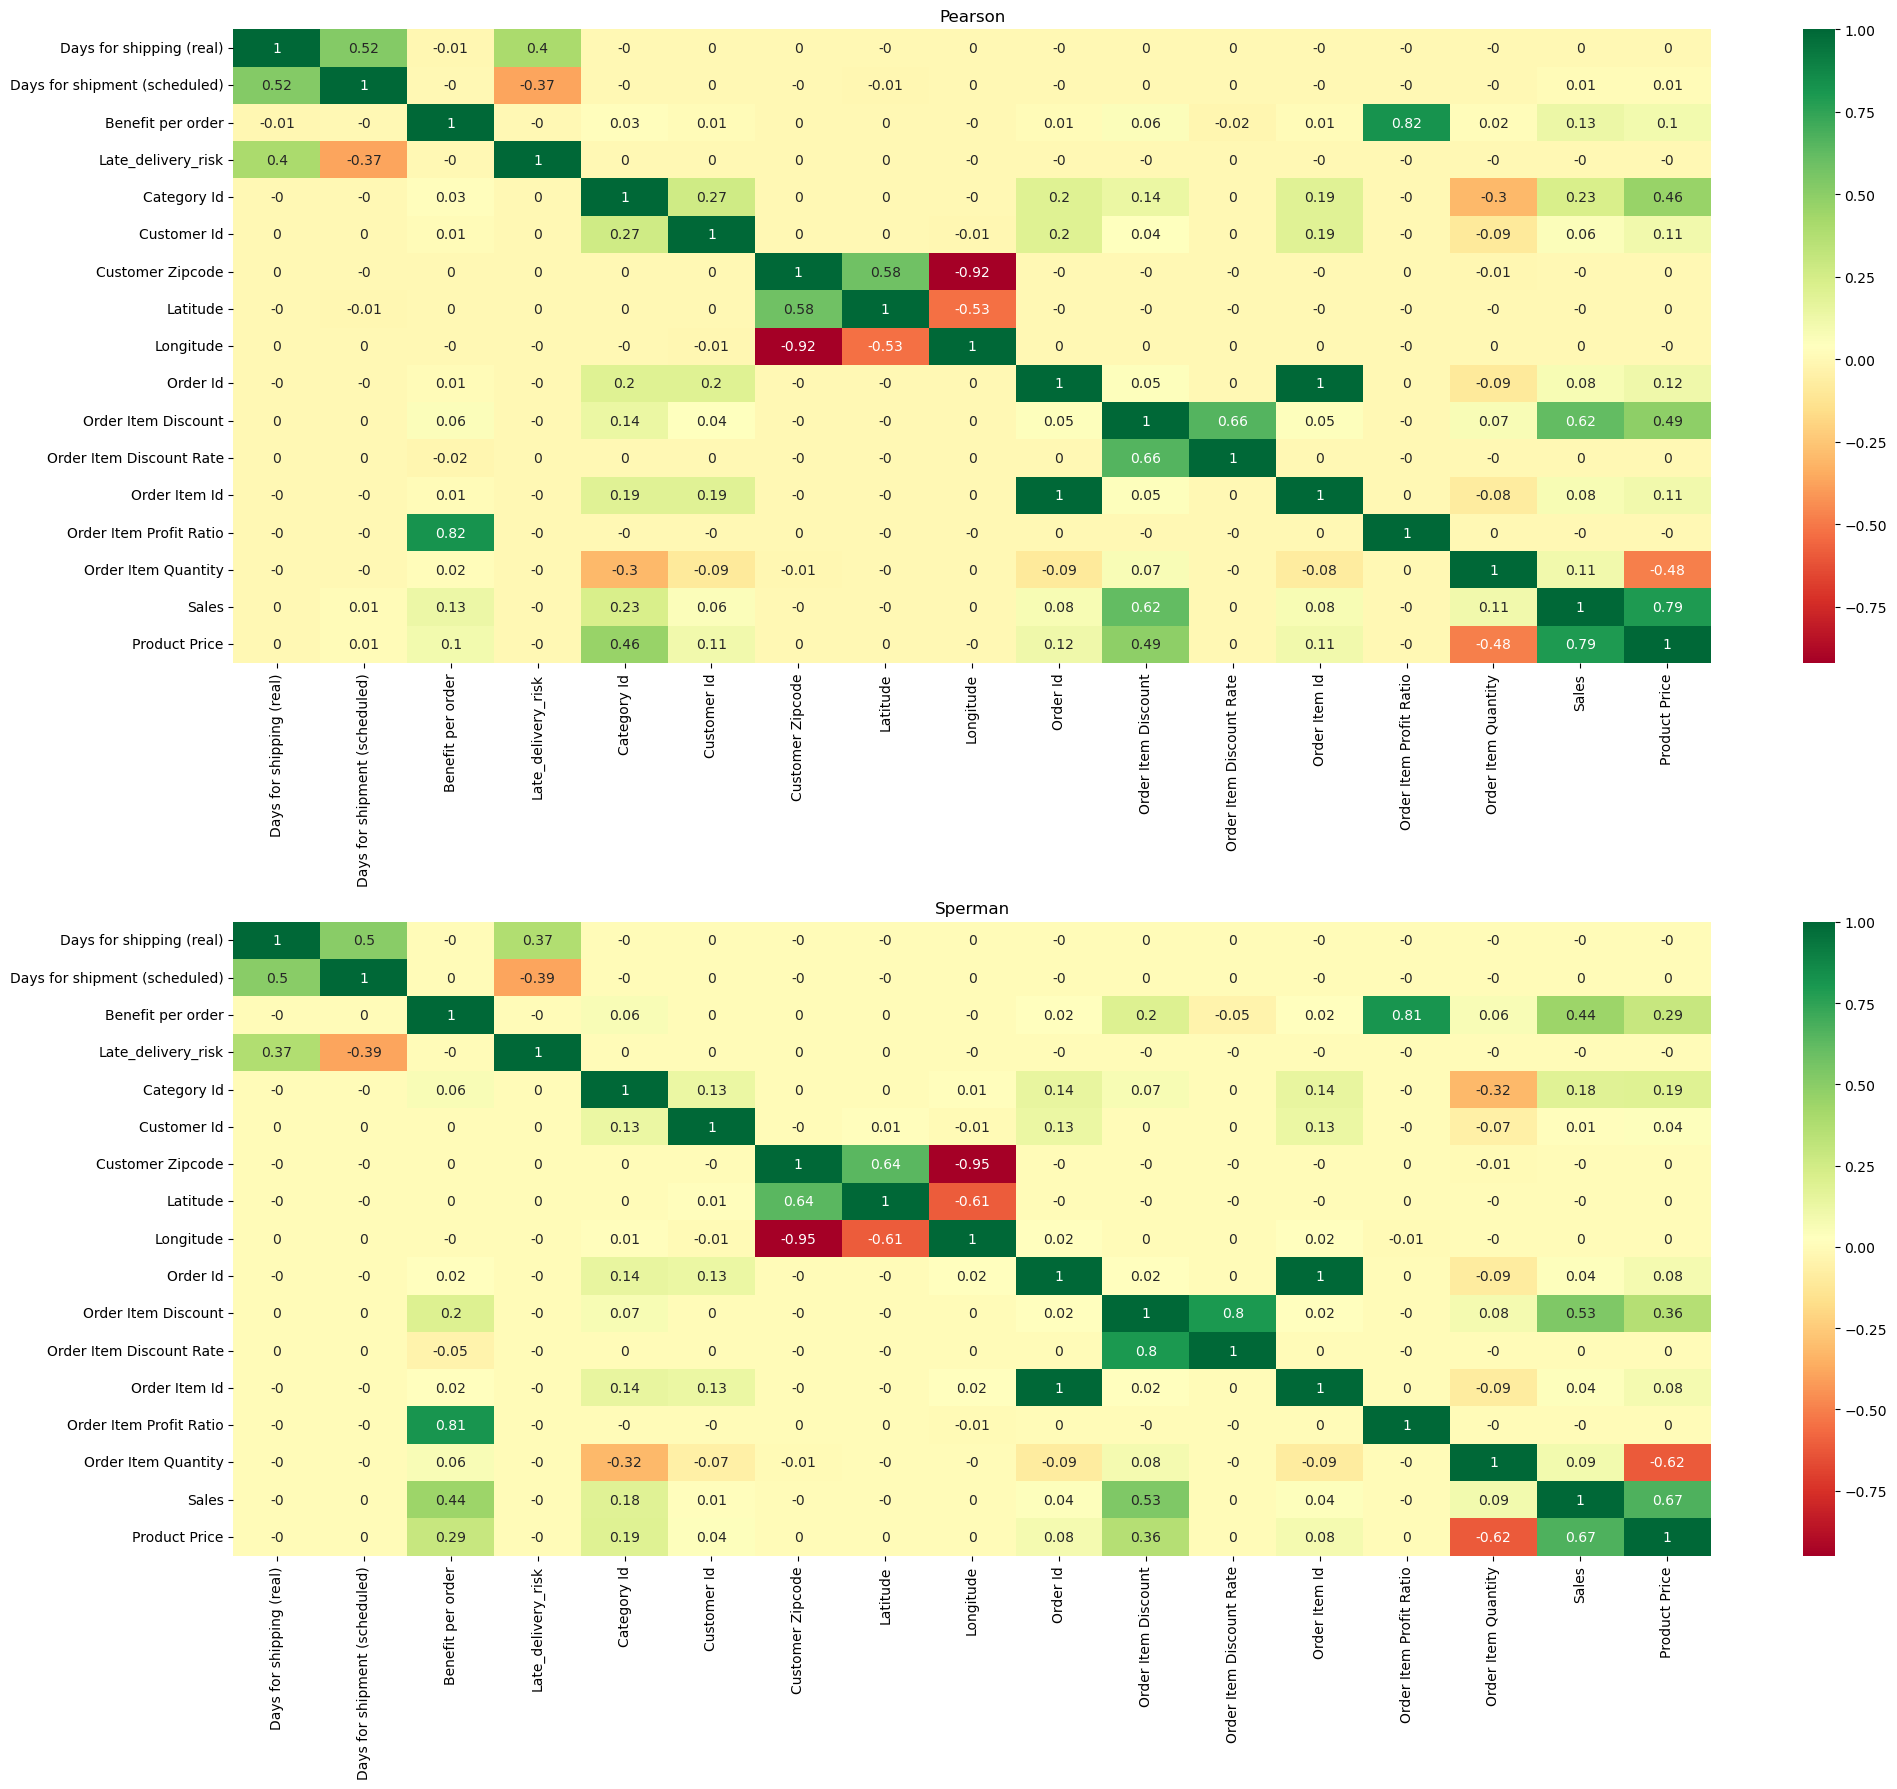

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
numerical_cols = df.select_dtypes(include = ['float', 'int']).columns.tolist()

_, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (21, 18))

sns.heatmap(df[numerical_cols].corr(method = 'pearson').round(2), annot = True, ax = axes[0], cmap="RdYlGn")
sns.heatmap(df[numerical_cols].corr(method = 'spearman').round(2), annot = True, ax = axes[1], cmap="RdYlGn")
axes[0].set_title('Pearson')
axes[1].set_title('Sperman')
plt.tight_layout()
plt.show()

#### Droping unnecessary data 2

Insights from Heatmap:
1. Columns that are similar with same values but with different metadata (duplicate columns)
    - Benefit per order, Order Profit Per Order
    - Sales per customer, Sales, Order Item Total
    - Category ID, Department Id, Order Item Cardprod ID, Product Category ID, Product Card ID
    - Customer Id, Order Customer ID, 
    - Order Item Product Price, Product Price


2. Unwanted features(null or less correlated values)
    - Product Status

In [ ]:
drop_cols = ['Order Profit Per Order', 'Sales per customer', 'Order Item Total', 'Department Id', 
             'Order Item Cardprod Id', 'Product Category Id', 'Product Card Id', 'Order Customer Id', 
             'Order Item Product Price', 'Product Status']
df.drop(columns = drop_cols,  inplace = True)

In [47]:
numerical_cols = df.select_dtypes(include = ['float', 'int']).columns.tolist()
categorical_cols = df.select_dtypes(include = ['object']).columns.tolist()
print("Numerical Features: ", len(numerical_cols))
print("Categorical Features: ", len(categorical_cols))

Numerical Features:  17
Categorical Features:  16


### Data Visualization

#### Features

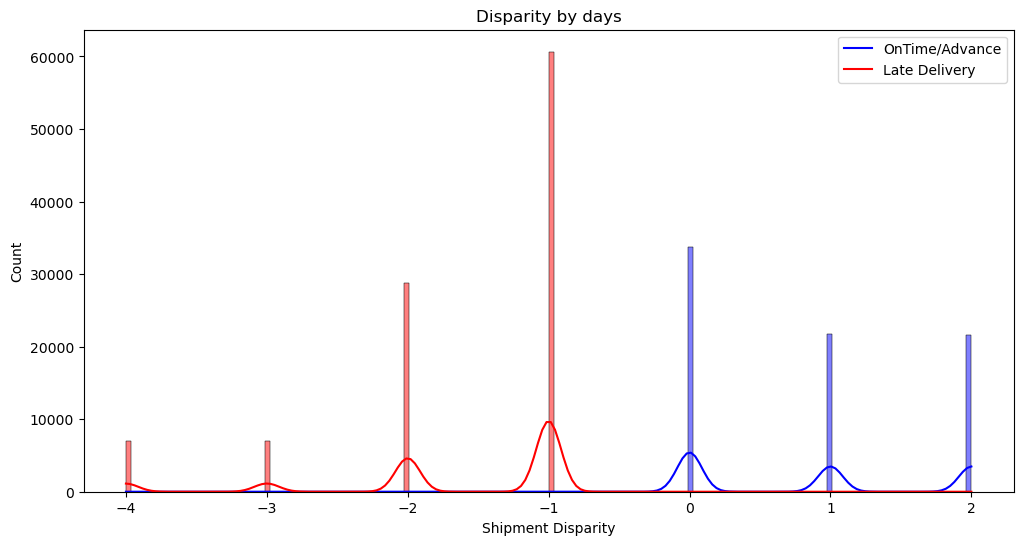

In [45]:
dd = pd.DataFrame()
plt.figure(figsize = (12, 6))
dd['Shipment Disparity'] = df['Days for shipment (scheduled)'] - df['Days for shipping (real)']
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data = dd, x = 'Shipment Disparity', kde = True, hue=dd['Shipment Disparity'] >= 0, palette=palette)
plot.legend(['OnTime/Advance', 'Late Delivery'])
plt.title('Disparity by days')
plt.show()

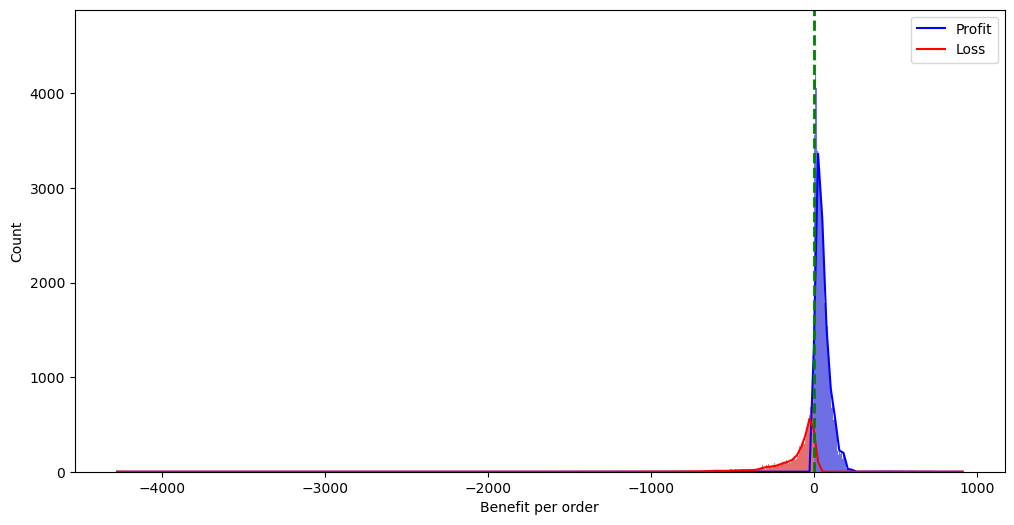

In [42]:
plt.figure(figsize = (12, 6))
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data = df, x = 'Benefit per order', kde = True, hue=df['Benefit per order'] > 0, palette=palette)
plt.axvline(0, color='green', linestyle='--', linewidth=2)
plot.legend(['Profit', 'Loss'])
plt.show()

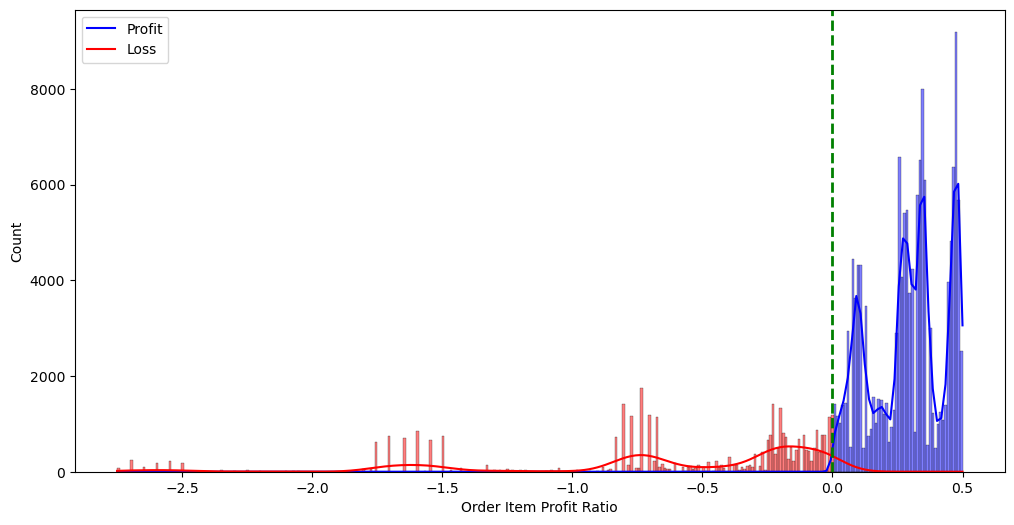

In [43]:
plt.figure(figsize = (12, 6))
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data = df, x = 'Order Item Profit Ratio', kde = True, hue=df['Order Item Profit Ratio'] > 0, palette=palette)
plt.axvline(0, color='green', linestyle='--', linewidth=2)
plot.legend(['Profit', 'Loss'])
plt.show()

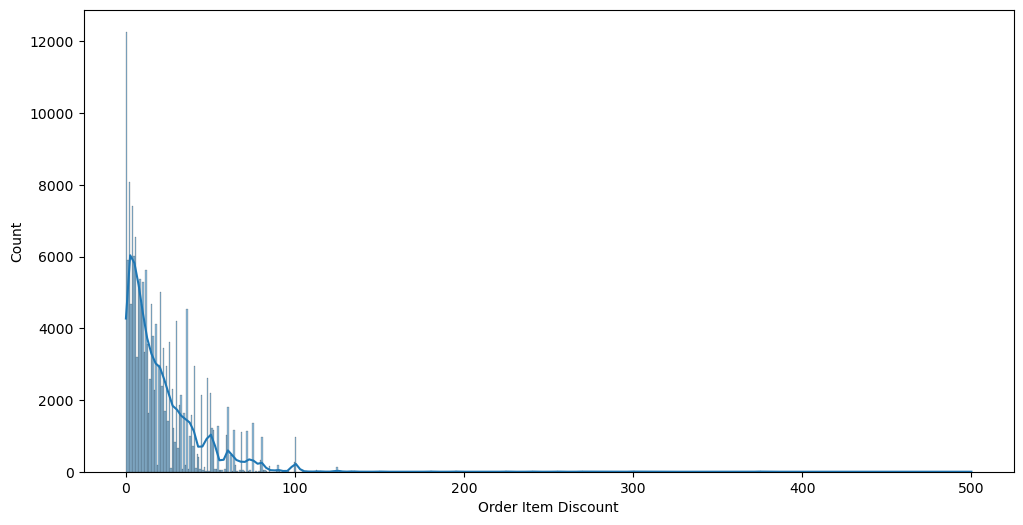

In [44]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Order Item Discount', kde = True)
plt.show()

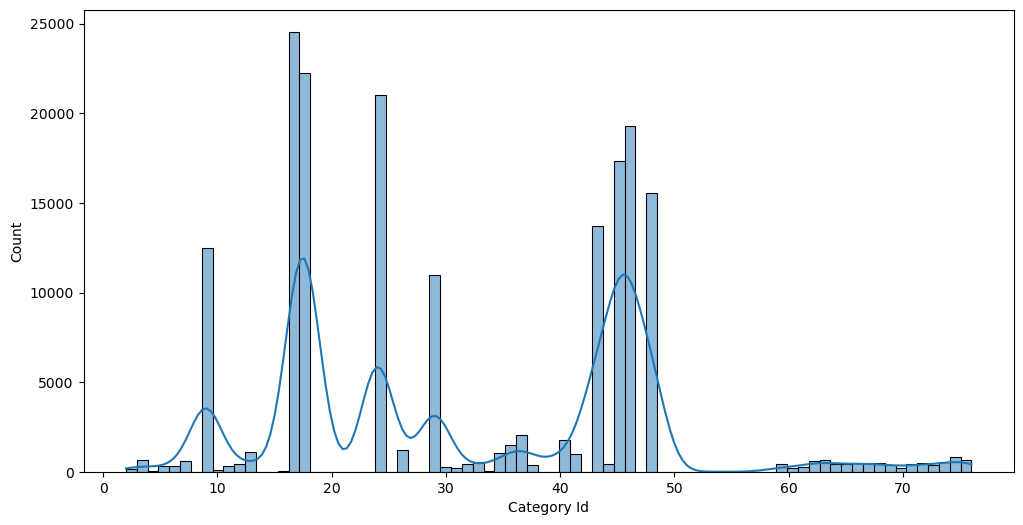

In [45]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Category Id', kde = True)
plt.show()

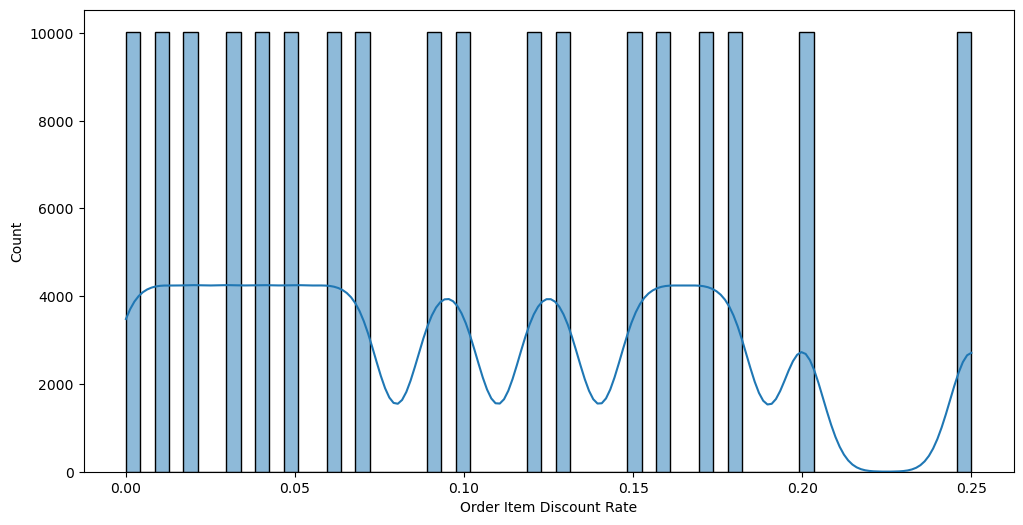

In [46]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Order Item Discount Rate', kde = True)
plt.show()

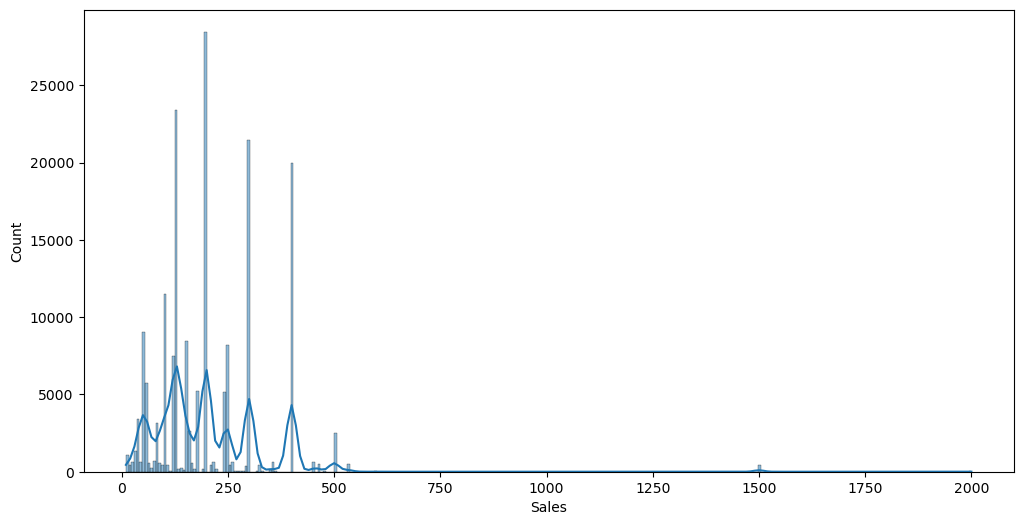

In [47]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Sales', kde = True)
plt.show()

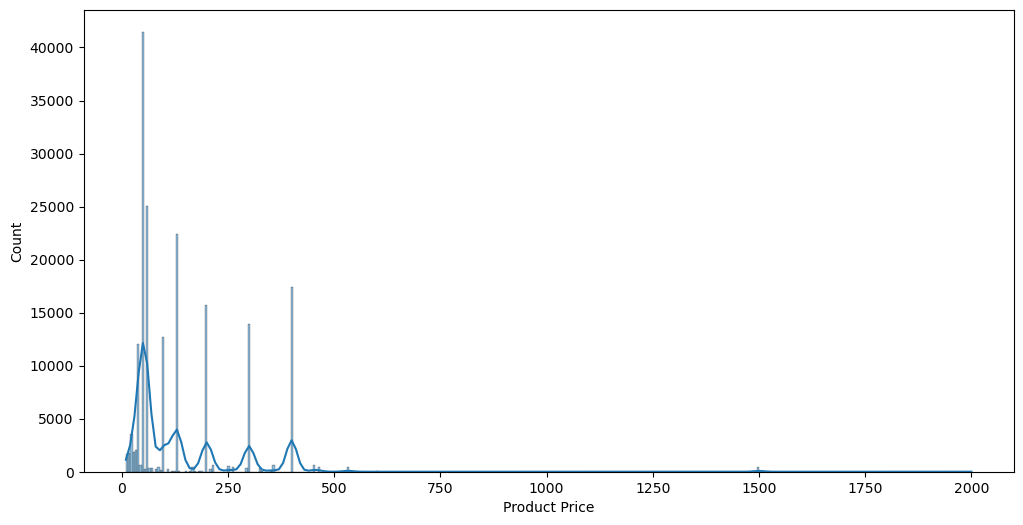

In [48]:
plt.figure(figsize=(12, 6))
plot = sns.histplot(data=df, x='Product Price', kde=True)
plt.show()


### Feature engineering

In [49]:
df['order_year'] = pd.DatetimeIndex(df['order date (DateOrders)']).year
df['order_month'] = pd.DatetimeIndex(df['order date (DateOrders)']).month
df['order_day'] = pd.DatetimeIndex(df['order date (DateOrders)']).day
df['shipping_year'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).year
df['shipping_month'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).month
df['shipping_day'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).day

In [50]:
df.drop(columns = ['order date (DateOrders)', 'shipping date (DateOrders)', 'Category Name'], inplace = True)
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Delivery Status,Late_delivery_risk,Category Id,Customer City,Customer Country,Customer Id,...,Order Status,Product Name,Product Price,Shipping Mode,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day
0,DEBIT,3,4,91.250000,Advance shipping,0,73,Caguas,Puerto Rico,20755,...,COMPLETE,Smart watch,327.75,Standard Class,2018,1,31,2018,2,3
1,TRANSFER,5,4,-249.089996,Late delivery,1,73,Caguas,Puerto Rico,19492,...,PENDING,Smart watch,327.75,Standard Class,2018,1,13,2018,1,18
2,CASH,4,4,-247.779999,Shipping on time,0,73,San Jose,EE. UU.,19491,...,CLOSED,Smart watch,327.75,Standard Class,2018,1,13,2018,1,17
3,DEBIT,3,4,22.860001,Advance shipping,0,73,Los Angeles,EE. UU.,19490,...,COMPLETE,Smart watch,327.75,Standard Class,2018,1,13,2018,1,16
4,PAYMENT,2,4,134.210007,Advance shipping,0,73,Caguas,Puerto Rico,19489,...,PENDING_PAYMENT,Smart watch,327.75,Standard Class,2018,1,13,2018,1,15


### Backup cleaned data

In [51]:
df.to_csv('cleanedData.csv')

In [52]:
import sagemaker
# Specify the SageMaker session
session = sagemaker.Session()

# Specify the S3 bucket name and folder
bucket_name = 'dsci-finalproject'
folder_name = 'data/cleaned'

# Specify the local CSV file path
local_file_path = 'cleanedData.csv'

# Upload the file to S3
s3_uri = session.upload_data(path=local_file_path, bucket=bucket_name, key_prefix=folder_name)

print("File uploaded successfully to the folder in the S3 bucket.")
print("S3 URI:", s3_uri)


File uploaded successfully to the folder in the S3 bucket.
S3 URI: s3://dsci-finalproject/data/cleaned/cleanedData.csv


### Data Prepration for modeling 

In [51]:
df2 = pd.get_dummies(df)
print(df2.shape)
df2.tail(2)

(180516, 5662)


,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Latitude,Longitude,Order Id,...,Product Name_adidas Brazuca 2014 Official Match Ball,Product Name_adidas Kids' F5 Messi FG Soccer Cleat,Product Name_adidas Men's F10 Messi TRX FG Soccer Cleat,Product Name_adidas Men's Germany Black Crest Away Tee,Product Name_adidas Youth Germany Black/Red Away Match Soc,Product Name_insta-bed Neverflat Air Mattress,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class
180517,3,4,186.229996,0,45,2813,725.0,18.21335,-66.370575,26022,...,False,False,False,False,False,False,False,False,False,True
180518,4,4,168.949997,0,45,7547,725.0,18.29038,-66.370613,26018,...,False,False,False,False,False,False,False,False,False,True


In [11]:
X = df2.drop(['Days for shipping (real)','Days for shipment (scheduled)'], axis=1)
y = df2[['Days for shipping (real)','Days for shipment (scheduled)']]
X.shape, y.shape

((180519, 5663), (180519, 2))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [13]:
# Concatenate y_train with X_train
train = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)

# Concatenate y_val with X_val
validation = pd.concat([y_val.reset_index(drop=True), X_val.reset_index(drop=True)], axis=1)

# Concatenate y_test with X_test
test = pd.concat([y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)


In [32]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

In [34]:
import sagemaker
# Specify the SageMaker session
session = sagemaker.Session()

# Specify the S3 bucket name and folder
bucket_name = 'dsci-finalproject'
folder_name = 'data/cleaned'

# Upload the CSV file to S3
train_s3_uri = session.upload_data(path='train.csv', bucket=bucket_name, key_prefix=folder_name)
val_s3_uri = session.upload_data(path='validation.csv', bucket=bucket_name, key_prefix=folder_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [57]:
import os
import boto3

# Save X_test to a CSV file without index and header
X_test.to_csv('test.csv', index=False, header=False)

# Upload the CSV file to the specified S3 bucket and prefix
s3_bucket = 'dsci-finalproject'
s3_folder = 'data/cleaned/'
s3_key = os.path.join(s3_folder, 'test/test.csv')

boto3.Session().resource('s3').Bucket(s3_bucket).Object(s3_key).upload_file('test.csv')


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


### Modeling

In [52]:
import sagemaker
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))


# Specify the S3 bucket name and folder
bucket = 'dsci-finalproject'
prefix = 'Model/XGB'

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


AWS Region: us-east-1
RoleArn: arn:aws:iam::590183878063:role/LabRole
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [53]:
xgb_model.set_hyperparameters(
    max_depth=5,                    # Maximum depth of a tree
    eta=0.2,                        # Learning rate
    gamma=4,                        # Minimum loss reduction required to make a further partition on a leaf node
    min_child_weight=6,             # Minimum sum of instance weight (hessian) needed in a child
    subsample=0.7,                  # Subsample ratio of the training instances
    objective="multi:softmax",      # Multi-class classification task with softmax
    num_class=7,                    # Number of classes for 'Days for shipping (real)'
    num_round=5                  # Number of boosting rounds
)


In [54]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://dsci-finalproject/data/cleaned/train.csv", content_type="csv"
)
validation_input = TrainingInput(
    "s3://dsci-finalproject/data/cleaned/validation.csv", content_type="csv"
)


In [55]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-04-21-00-00-28-184


2024-04-21 00:00:28 Starting - Starting the training job...
2024-04-21 00:00:51 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2024-04-21 00:01:23 Downloading - Downloading input data...............
2024-04-21 00:03:52 Training - Training image download completed. Training in progress.[2024-04-21 00:03:48.348 ip-10-2-78-91.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delim

### Deploy

In [79]:
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-04-20-21-23-04-539


In [55]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2024-04-20-20-26-53-235'

### Prediction

In [58]:
import sagemaker
xgb_predictor_reuse=sagemaker.predictor.Predictor(
    endpoint_name="sagemaker-xgboost-2024-04-20-20-26-53-235",
    sagemaker_session=sagemaker.Session(),
    serializer=sagemaker.serializers.CSVSerializer()
)

In [59]:
# The location of the test dataset
batch_input = 's3://dsci-finalproject/data/cleaned/test'

# The location to store the results of the batch transform job
batch_output = 's3://dsci-finalproject/Model/XGB/batch-prediction'


In [60]:
transformer = xgb_model.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge', 
    output_path=batch_output
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-04-21-00-13-56-782


In [ ]:
transformer.transform(
    data=batch_input, 
    data_type='S3Prefix',
    content_type='text/csv', 
    split_type='Line'
)
transformer.wait()

### Model Evaluation

In [ ]:
y_pred = xgb_predictor_reuse.predict(X_test)

In [42]:
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',round(a, 2))
    print('The mean squared error is',round(b, 2))
    print('The mean accuracy score is',round(c, 2))
    
metrics(y_test, y_pred)

The r-squared score of the model is  0.99
The mean squared error is 0.03
The mean accuracy score is 0.02


In [43]:
# Convert the predictions array into a DataFrame
prediction = pd.DataFrame(y_pred, columns=['Predicted_Label'])

# Display the first few rows of the prediction DataFrame
prediction.head()

,0,1
0,2.0,4.0
1,1.0,0.0
2,6.0,4.0
3,2.0,4.0
4,2.0,2.0
